In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torch import nn, Tensor
import torch.nn.functional as F
import pandas as pd

import vit
import vit1
from helper import *

In [2]:
if torch.cuda.is_available() and USE_CUDA == True:
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
DATASET = 1

# USE 0 for combined dataset, use 1 for anm1, use 2 for anm2, and 3 for adni

In [4]:
nets = ["combined", "anm1", "anm2", "adni"]
datasets = ["", "1", "2", "_adni"]

In [5]:
train = geneDataset(f"train{datasets[DATASET]}")
test = geneDataset(f"test{datasets[DATASET]}")

In [6]:
trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

In [7]:
net = torch.load(f"nets/{nets[DATASET]}.pt")
net.to(device)

VisionTransformer(
  (embedding_layer): EmbeddingStem(
    (pos_drop): Dropout(p=0.95, inplace=False)
    (projection): Sequential(
      (0): Conv2d(1, 24, kernel_size=(4, 4), stride=(4, 4))
    )
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (qkv): Linear(in_features=24, out_features=72, bias=False)
            (attn_drop): Dropout(p=0.95, inplace=False)
            (proj): Linear(in_features=24, out_features=24, bias=True)
            (proj_drop): Dropout(p=0.95, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Conv1d(24, 48, kernel_size=(1,), stride=(1,))
            (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate=none)
            (3): Dropout(p=0.95, inplace=False)
            (4): Con

In [8]:
total_params = sum(p.numel() for p in net.parameters())
print(total_params)

11809


In [9]:
pos = 0
neg = 0

wrong = 0
right = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data

        X = X.to(device)
        y = y.to(device)
        
        net.eval()

        output = torch.clamp(net(X), min=0.0, max=1.0)

        for i in range(len(output)):
            if y[i][0] == round(float(output[i][0])):
                right += 1
            else:
                wrong += 1

            total += 1

print(right / total)

0.8367346938775511


In [10]:
RES = 1000

In [11]:
falsePos = [0] * RES
truePos = [0] * RES
falseNeg = [0] * RES
trueNeg = [0] * RES

In [12]:
from tqdm.notebook import tqdm

with torch.no_grad():
    for data in tqdm(testset):
        X, y = data
        
        X = X.to(device)
        y = y.to(device)
        
        net.eval()

        output = net(X)
        
        for i in range(RES):
            loss = wrongAns(output, y, 2 * i / (RES - 1) - 0.5)
            truePos[i] += loss[0]
            falsePos[i] += loss[1]
            trueNeg[i] += loss[2]
            falseNeg[i] += loss[3]

  0%|          | 0/5 [00:00<?, ?it/s]

290


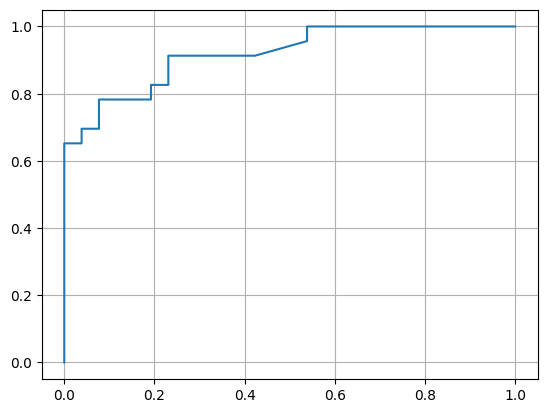

In [13]:
hAcu = 0

falsePosRate = []
truePosRate = []

for i in range(len(truePos)):
    falsePosRate.append(falsePos[i] / (falsePos[i] + trueNeg[i]))
    truePosRate.append(truePos[i] / (truePos[i] + falseNeg[i]))

for i in range(RES):
    if hAcu < truePos[i] + trueNeg[i]:
        hAcu = truePos[i] + trueNeg[i]
        lowestIndex = i

print(lowestIndex)
    
plt.plot(falsePosRate, truePosRate)
plt.grid()

In [14]:
import sklearn.metrics

auc = sklearn.metrics.auc(falsePosRate, truePosRate)

print(auc)

0.918896321070234


In [15]:
data = iter(testset)

tensor([0.], device='cuda:0')


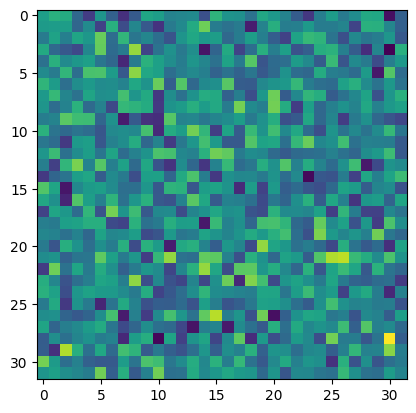

In [16]:
X, y = data.next()

X = X.to(device)
y = y.to(device)
        
output = net(X)

print(y[0])
plt.imshow(X[0].view((32, 32)).cpu())

In [17]:
i = 0

tensor([0.], device='cuda:0')
tensor([-0.0134], device='cuda:0', grad_fn=<SelectBackward0>)


1

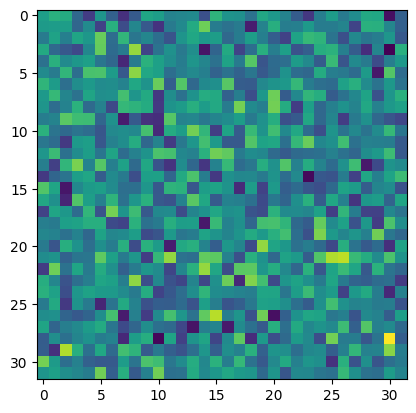

In [18]:
print(y[i])
print(output[i])
plt.imshow(X[i].view((32, 32)).cpu())

i += 1
i %= 100

i

In [19]:
print(y.view(-1))

tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 1.], device='cuda:0')


In [20]:
print(output.view(-1))


tensor([-0.0134,  0.0069,  0.0026,  0.0130,  0.9927,  0.9698,  0.5970,  0.0734,
         0.0197,  0.9936], device='cuda:0', grad_fn=<ViewBackward0>)


In [21]:
print(X)

tensor([[[[ 0.5640,  0.6523,  0.6311,  ...,  0.6100, -0.0611,  0.2601],
          [ 0.5453,  0.5545,  0.5619,  ...,  0.6495,  0.4448,  0.2624],
          [ 0.3911,  0.5828,  0.4115,  ...,  0.4010,  0.5224,  0.2240],
          ...,
          [ 0.2462,  0.0618,  0.9520,  ...,  0.4309,  0.8784,  0.4008],
          [ 0.8430,  0.5490,  0.3290,  ...,  0.2089,  0.3319,  0.3849],
          [ 0.5124,  0.5766,  0.4868,  ...,  0.3287,  0.5545,  0.4294]]],


        [[[ 0.3039, -0.0451,  0.6269,  ...,  0.5492,  0.2357,  0.5315],
          [ 0.6016,  0.5554,  0.8449,  ..., -0.0635,  0.6606,  0.5467],
          [ 0.2321,  0.2854,  0.7089,  ...,  0.4617,  0.7809,  0.2895],
          ...,
          [ 0.7490,  0.5032,  0.1949,  ...,  0.5190,  0.4202,  0.5126],
          [ 0.4880,  0.3368,  0.3779,  ...,  0.2692,  0.9404,  0.5819],
          [ 0.3971,  0.2476,  0.0581,  ...,  0.4534,  0.3059,  0.6161]]],


        [[[ 0.3024,  0.3424,  0.3016,  ...,  0.5481,  0.2237,  0.5688],
          [ 0.2680,  0.232